# <u>**EEG NeuroImaging Analysis (EEGNIA)**</u>
by Derek Newman

* These exercises are designed to orient the user to power analysis and the aperiodic slope.

# 2. Introduction to Power Analysis

<u>Table of Contents</u>
1. Power Analysis
2. Aperiodic Slope

In [ ]:
# Power analysis
# Bands power.
# aperiodic slops
# oscillation and aperiodic = brain signal.
# Foof SLope and offset.

In [ ]:
!pip install mne

In [ ]:
#!pip install ipympl # A package to help visualization  of our data within this notebook

In [ ]:
!pip install fooof

In [ ]:
# Import packages
import matplotlib.pyplot as plt # A visualization package for creating plots and graphs.
import numpy as np # A library for numerical computations and array manipulations.
import scipy as sp # A scientific computing library with functions for optimization, integration, and more.
import pandas as pd # A data analysis library with structures for handling and manipulating tabular data (known as DataFrames).
import seaborn as sb # A statistical visualization library for more sophisticated plots.
import mne # Import the package we just downlaoded
import glob
import fooof as fooof # The software package to measure the aperiodic slope.
%matplotlib widget

<ipython-input-4-a8fa868187a3>:9: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  import fooof as fooof # The software package to measure the aperiodic slope.


In [ ]:
# Run this to help with our visuals so we can click and play with them
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from mne.datasets import sample #EEGBCI, bst_resting (other dat sets)

# Load the sample dataset (this might take a few minutes)
data_path = sample.data_path()

In [ ]:
# Write in 'f-strings' format
raw_path = f"{data_path}/MEG/sample/sample_audvis_raw.fif"

# Load raw data
raw = mne.io.read_raw_fif(raw_path, preload=True)
# The file has MEG and EEG data, let's just take the EEG
raw_eeg = raw.pick_types(meg=False, eeg=True)

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


<ipython-input-8-2eaf99f375df>:4: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_eeg.plot_psd()


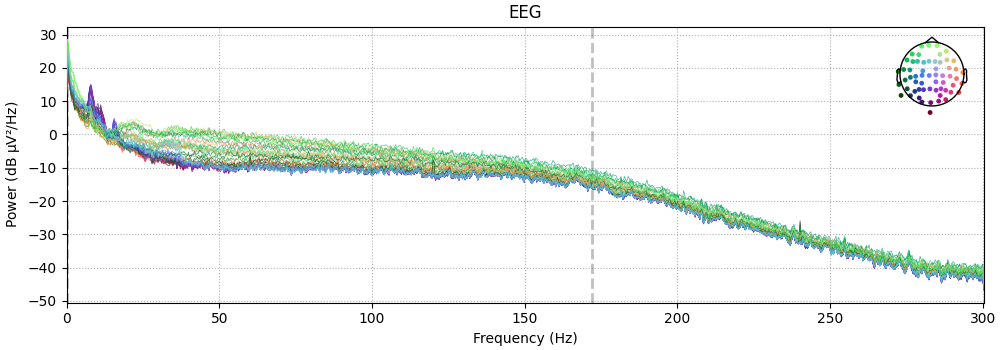

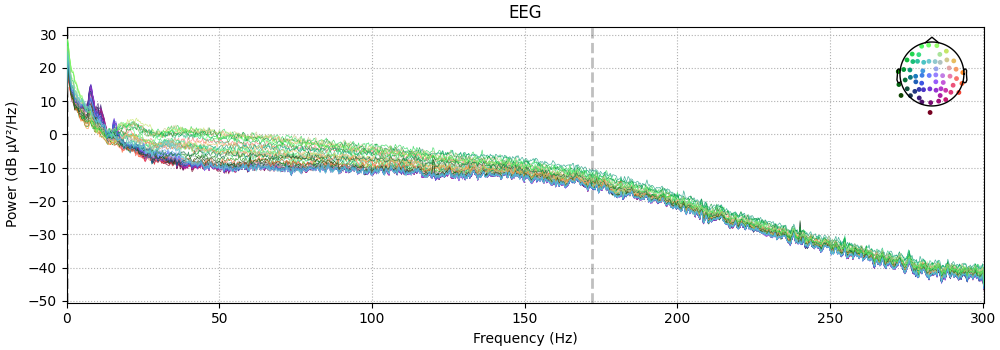

In [ ]:
# As previously considered, we can examine the frequency domain of a signal, below is the Power Spectral Density Plot
# It is a way of visualizing signals as a summation of its component frequencies.
# On th Y axis we can see Power,  or Energy of the signal and the X axis are frequency
raw_eeg.plot_psd()
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


<ipython-input-9-2956651ac7ee>:4: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_eeg.plot_psd(fmin= 8,fmax=13)


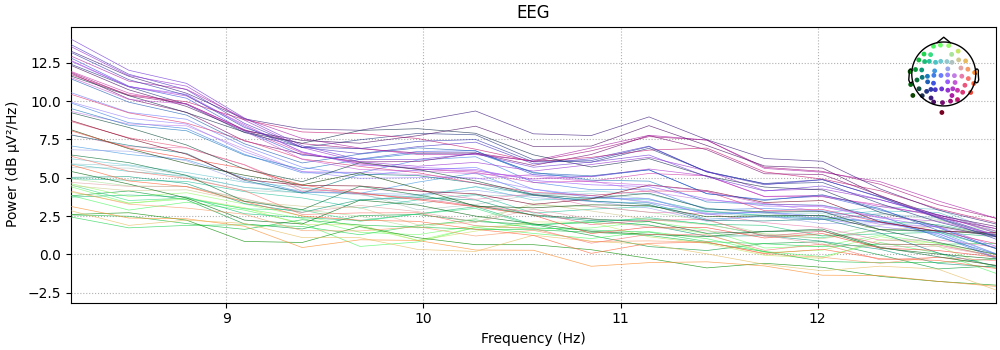

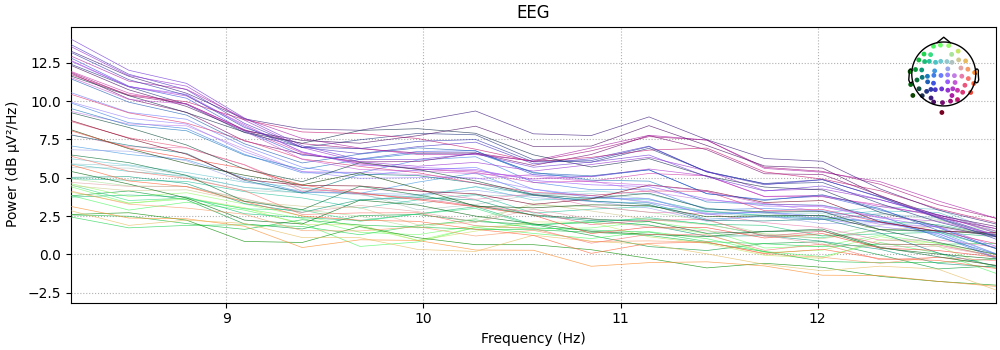

In [ ]:
# We also previously inspected filtering signals based on frequency
# For example the low pass, high pass, band pass and notch filter.
# Let's say we only wanted to see the activity greater than 8 hz but less than 13 (The alpha band)
raw_eeg.plot_psd(fmin= 8,fmax=13)
plt.show()

In [ ]:
# We can also filter the signal by its "Canonical" (Standard) frequency bands of analysis listed below:
# Function for extraction frequency bands
freq_bands = {'delta': (1, 4),
              'theta': (4, 8),
              'alpha': (8, 13),
              'beta': (13, 30),
              'low-gamma': (30, 45)}

# A function to bandpass all canonical bands and return a list of signals are:
def bandpass_filter(signal, sfreq, freq_bands):
    """Applies bandpass filters to the given signal for each specified frequency band."""
    filtered_signals = {}
    for band, freq in freq_bands.items():
        filtered_signals[band] = mne.filter.filter_data(signal, sfreq=sfreq, l_freq=freq[0], h_freq=freq[1], verbose=False)
    return filtered_signals

In [ ]:
# Lets grab one time series from 1 channel from all the channels to inspect
# Note if we want to do a global analysis (i.e. the whole brain) we would perform the these technqieus on all channels and use method to aggregate them
time_series = raw_eeg.get_data()[0]

In [ ]:
time_series

array([1.13989260e-05, 9.85015885e-06, 7.68188489e-06, ...,
       2.82495122e-05, 2.28598026e-05, 2.38510136e-05])

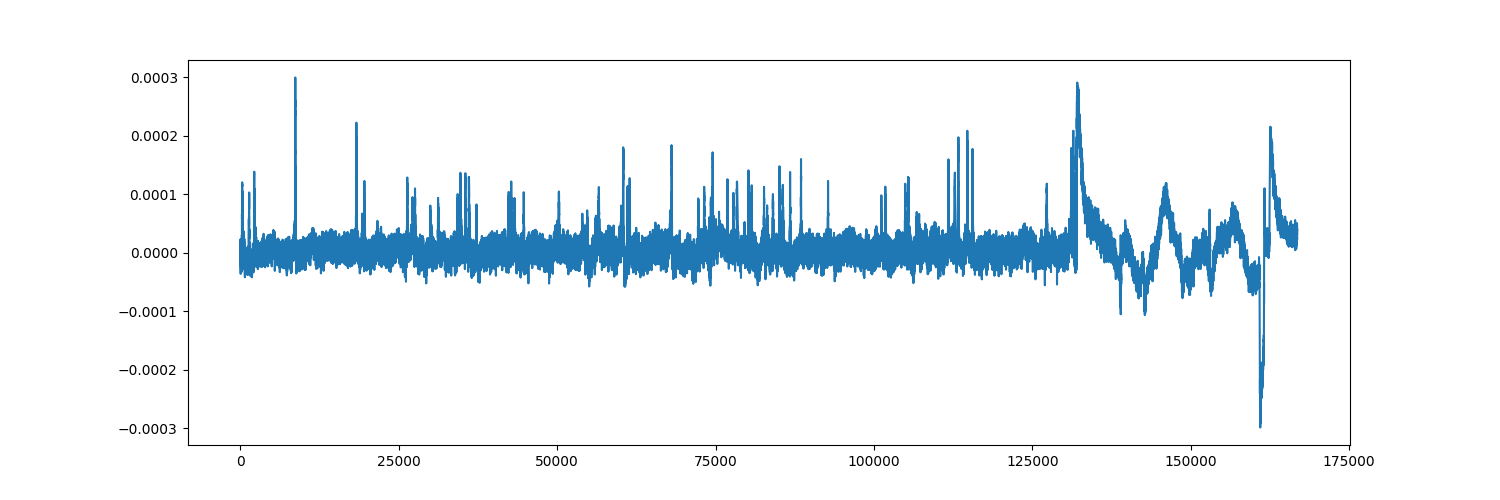

In [ ]:
# Lets visualize it, we need an x to plot for time points lets take the range fo the length of time series values
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(time_series)), time_series)
plt.show()

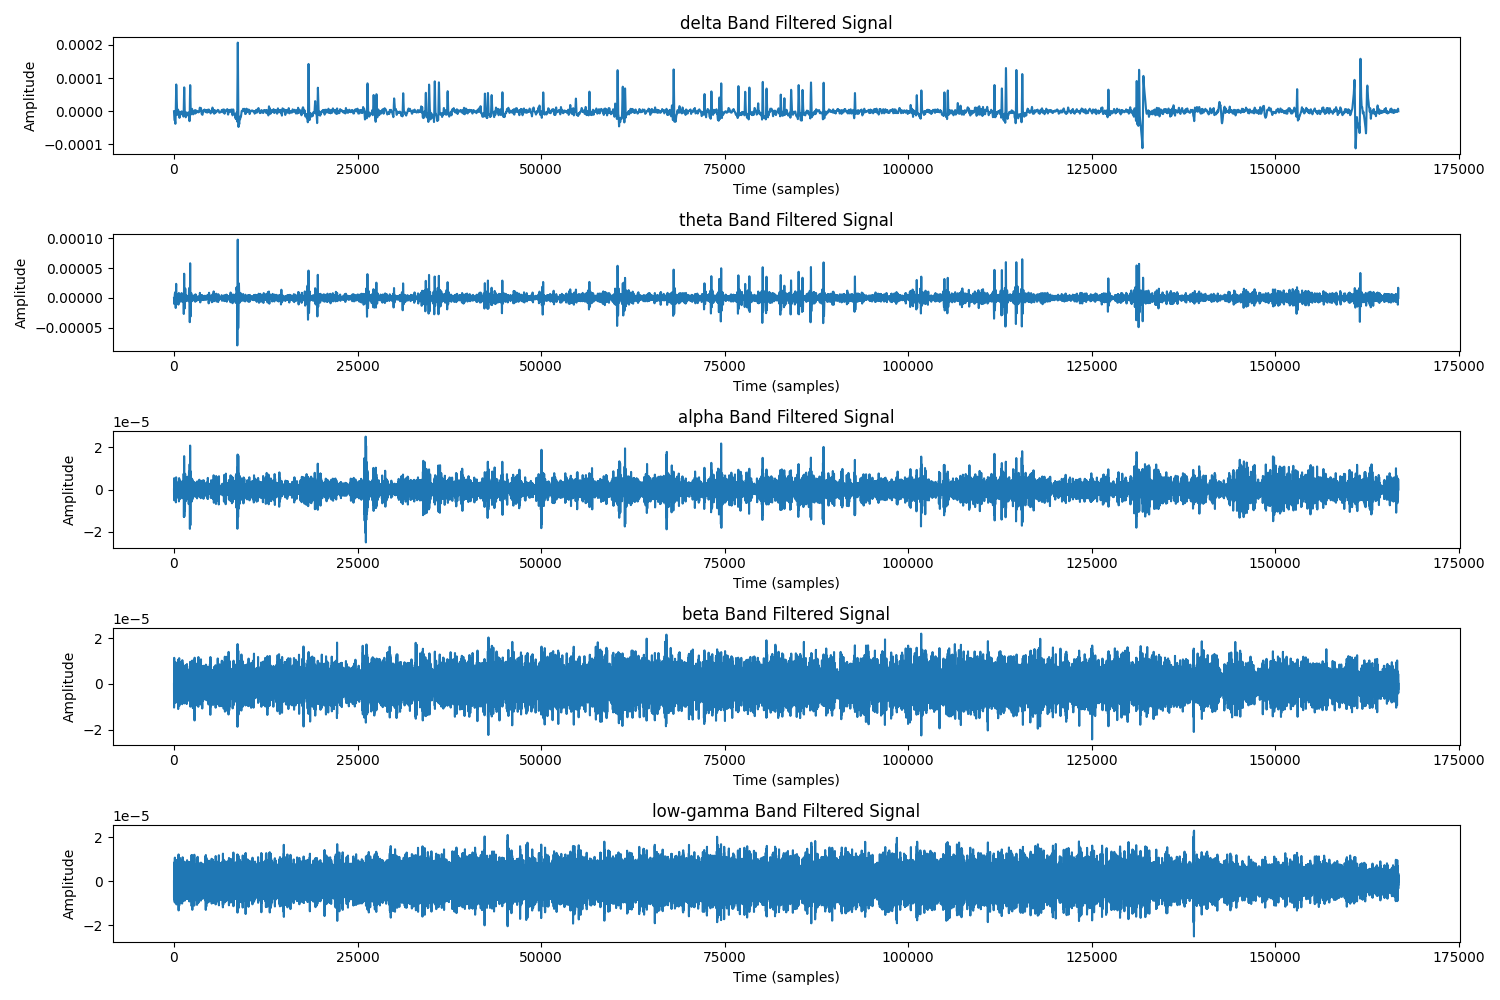

In [ ]:
# Now lets filter each frequency band and plot it!
# Lets get the sampling frequency stored in the info of the file
sfreq = raw_eeg.info['sfreq']

# Apply bandpass filters
filtered_signals = bandpass_filter(time_series, sfreq, freq_bands)

# Plot the filtered signals
fig, axs = plt.subplots(len(freq_bands), figsize=(15, 10))

for i, (band, filtered_data) in enumerate(filtered_signals.items()):
    axs[i].plot(filtered_data.T)
    axs[i].set_title(f'{band} Band Filtered Signal')
    axs[i].set_xlabel('Time (samples)')
    axs[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [ ]:
# Try and do the same on another signal from raw_eeg

In [ ]:
# You can also try and plot the psd of the filteres signal along with the time series


# Power Analysis

At times we might want to quantify how much power from one band is present in a signal. A way of doing this is calculating the area under the slope of the PSD, we can break it apart by canonical frequency bands and use the area as an approximation to the amount of "band power".

In [ ]:
sfreq

array([0.00000000e+00, 1.66496011e-03, 3.32992022e-03, ...,
       2.77710351e+02, 2.77712016e+02, 2.77713681e+02])

In [ ]:
# Here is one method to calculate the Absolute and relative power via the area under the curve of the PSD

from scipy.integrate import simps # used to calculate our integrals
from scipy.signal import welch # function to calculate psd - power and frequency values
#from mne.time_frequency import psd_array_welch (we can do this in mne too)

# below function is from: https://raphaelvallat.com/bandpower.html, great page to read!
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

# A great additional resource https://raphaelvallat.com/bandpower.html to explore the process.

In [ ]:
# Define the duration of the window to be 4 seconds
win_sec = 4

# Delta band the absolute power
db = bandpower(time_series, sfreq, [0.5, 4], win_sec)
# Delta band the relative power
db_rel = bandpower(time_series, sfreq, [0.5, 4], win_sec, True)


In [ ]:
print(db)
print(db_rel)

2.889310800393856e-10
0.4218212730051454


In [ ]:
# Use the freqeuncy bands specified and calculate the absolute and relative power of each band


In [ ]:
# Extra: try to write a function that given a time_series it will return a dictionary with the absolute and relative band powers using the funciton above



In [ ]:
# We can also use it to calculate the ratio of any powers, such as in :
# Define the duration of the window to be 4 seconds
win_sec = 4

# Delta/beta ratio based on the absolute power
db = bandpower(time_series, sfreq, [0.5, 4], win_sec) / bandpower(time_series, sfreq, [12, 30], win_sec)

# Delta/beta ratio based on the relative power
db_rel = bandpower(time_series, sfreq, [0.5, 4], win_sec, True) / bandpower(time_series, sfreq, [12, 30], win_sec, True)

print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Delta/beta ratio (absolute): 13.839
Delta/beta ratio (relative): 13.839


# The Aperiodic Slope using FOOOF

We can quantify and inspect the absolute and relative pwoers of a signal... but the slope of the PSD curve has much of this info (indirectly), we can distinguish signals based on their "1/f" property. The FOOOF software was developed to use advanced modeling techqniues to fit the one over f curve. The functions would return a slope and offset paramter which offset reflects the initial value of the signal. Look at the links below to to delve further.

In [ ]:
# Links: https://fooof-tools.github.io/fooof/index.html
# https://fooof-tools.github.io/fooof/auto_tutorials/plot_01-ModelDescription.html#sphx-glr-auto-tutorials-plot-01-modeldescription-py

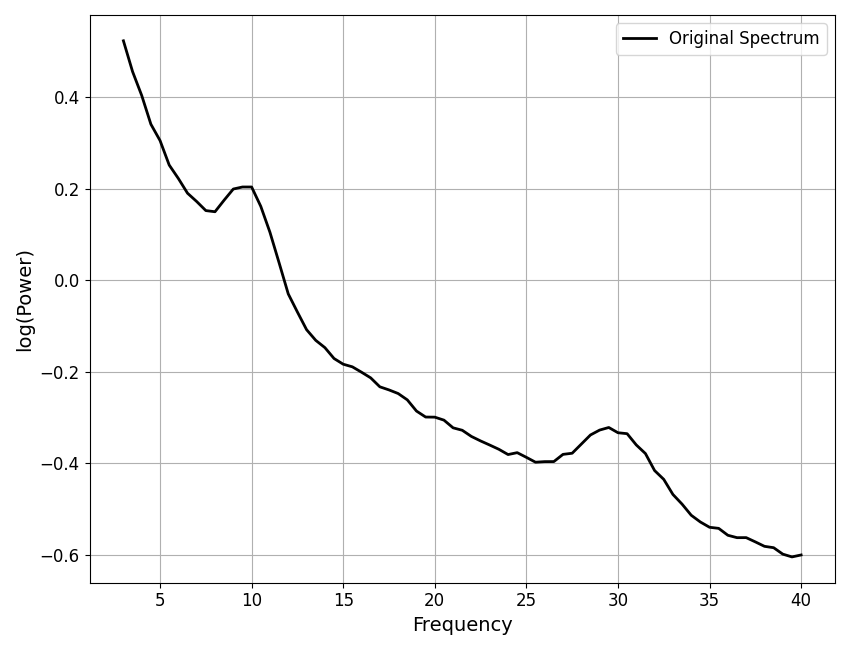

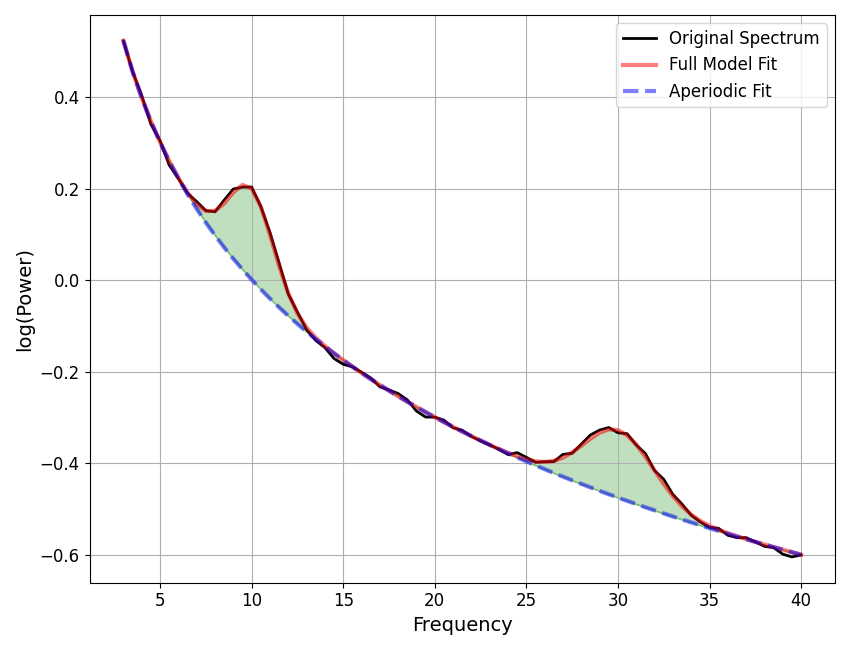

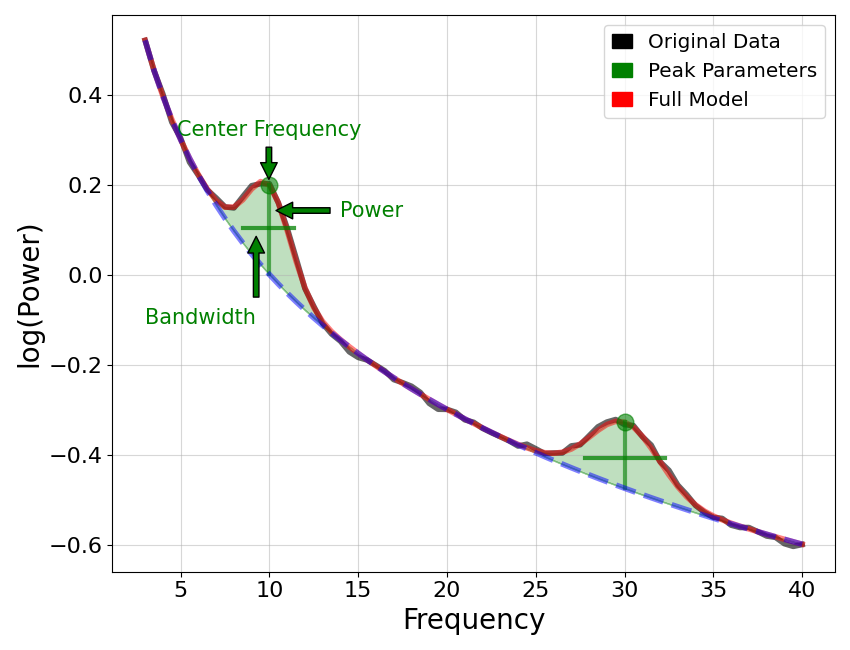

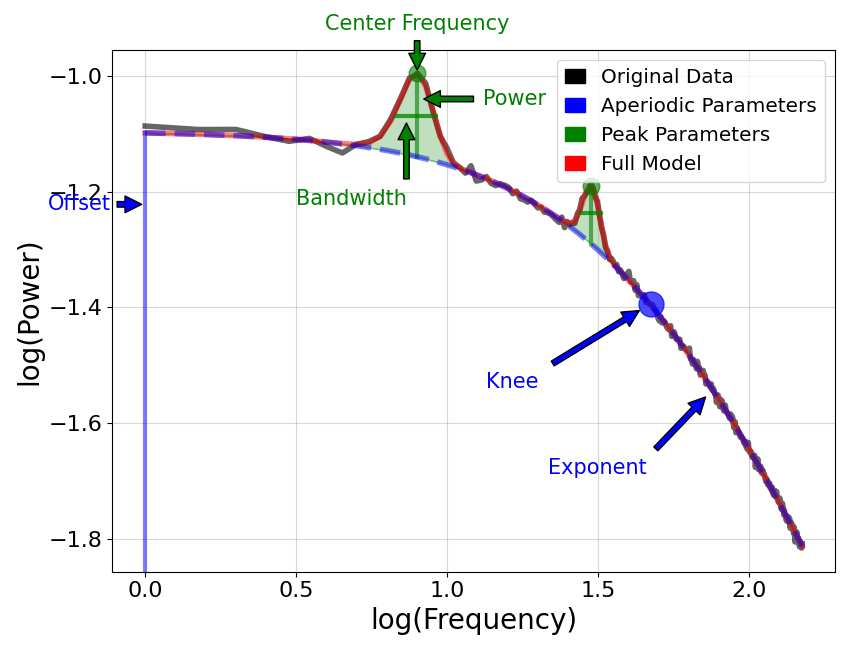

Aperiodic parameters (offset, exponent): [0.99857759 0.99733971]
Aperiodic parameters with knee (offset, knee, exponent): [  0.99067397 121.75494073   1.2459004 ]


In [ ]:
# Below is taken from the FOOOF tutorial online (link above)

# For below, read the document and explore the "knee" option and why it would be needed

# Import necessary libraries from FOOOF
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model

# Set random seed for reproducibility
set_random_seed(21)

# Simulate example power spectra
freqs1, powers1 = gen_power_spectrum([3, 40], [1, 1], [[10, 0.2, 1.25], [30, 0.15, 2]])
freqs2, powers2 = gen_power_spectrum([1, 150], [1, 125, 1.25], [[8, 0.15, 1.], [30, 0.1, 2]])

# Initialize and fit the FOOOF model
fm1 = FOOOF(min_peak_height=0.05, verbose=False)
fm2 = FOOOF(min_peak_height=0.05, aperiodic_mode='knee', verbose=False)
fm1.fit(freqs1, powers1)
fm2.fit(freqs2, powers2)

# Plot the original power spectrum
plot_spectra(freqs1, powers1, log_powers=True, color='black', label='Original Spectrum')
plt.show()

# Plot the model fit
fm1.plot(plot_peaks='shade', peak_kwargs={'color': 'green'})
plt.show()

# Annotate the model
plot_annotated_model(fm1, annotate_aperiodic=False)
plt.show()

plot_annotated_model(fm2, plt_log=True)
plt.show()

# Extract and explore the aperiodic parameters
aperiodic_params = fm1.aperiodic_params_
print("Aperiodic parameters (offset, exponent):", aperiodic_params)

aperiodic_params_knee = fm2.aperiodic_params_
print("Aperiodic parameters with knee (offset, knee, exponent):", aperiodic_params_knee)

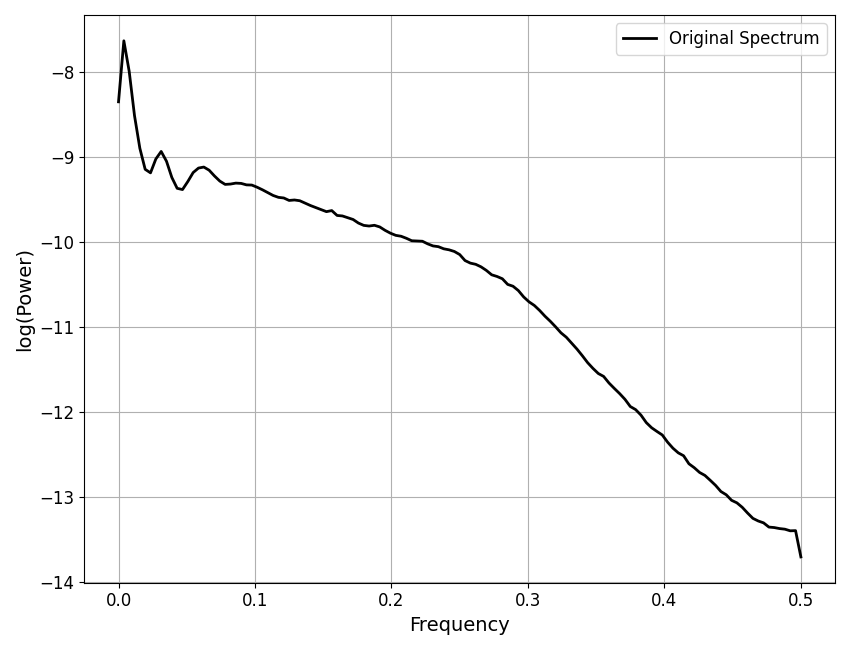

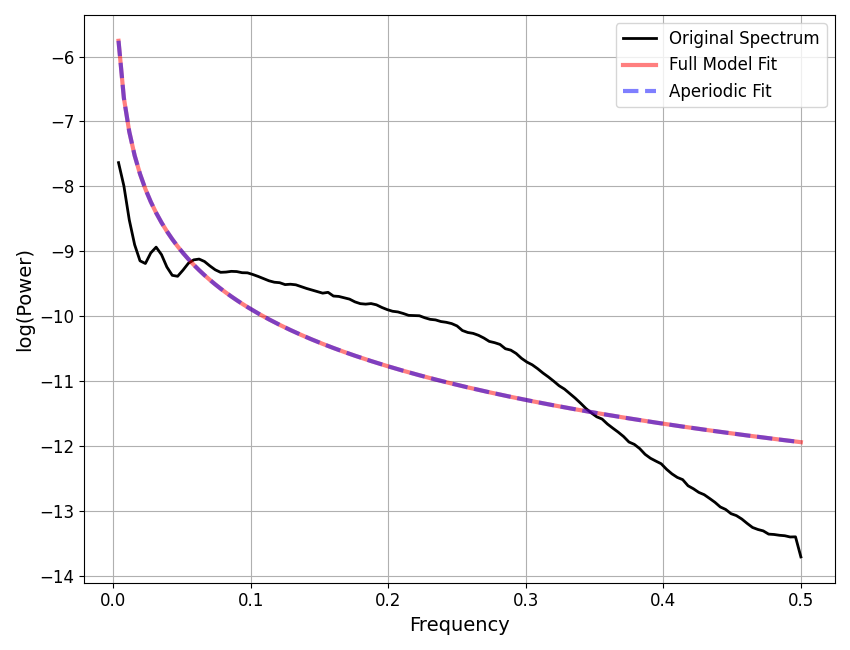

In [ ]:
# Try and use this on multiple timeseries from our EEG

freqs, powers = welch(time_series)
# Initialize and fit the FOOOF model
fm1 = FOOOF(min_peak_height=0.05, verbose=False)
fm1.fit(freqs, powers)

# Plot the original power spectrum
plot_spectra(freqs, powers, log_powers=True, color='black', label='Original Spectrum')
plt.show()

# Plot the model fit
fm1.plot(plot_peaks='shade', peak_kwargs={'color': 'green'})
plt.show()

In [ ]:
# FOOOF is being deprecated and is replaced by specparam, I have yet to use it! Try and encorporate the Specparam version for a challenge :)

We have explored:
1. The power spectrum
2. Frequency band filtering
3. Plotting filtered times series
4. Calculating absolute and relative power
5. Calculating the Apreriodic slope.